# Análise de Similaridade Entre Logs Apache Diários e Dia da Invasão (TF-IDF + Similaridade)

## 1. Leitura dos Arquivos de Log

In [46]:
import os
import glob
import re

In [47]:
def ler_logs_por_arquivo(diretorio, arquivo_invasao):
    documentos = {}
    for caminho in sorted(glob.glob(os.path.join(diretorio, "log*"))):
        try:
            with open(caminho, 'r', encoding='utf-8', errors='ignore') as f:
                documentos[os.path.basename(caminho)] = f.read()
        except Exception as e:
            print(f"Erro ao ler {caminho}: {e}")

    # Carregar o log de invasão separadamente
    try:
        with open(arquivo_invasao, 'r', encoding='utf-8', errors='ignore') as f:
            documentos["LOG_INVASAO"] = f.read()
    except Exception as e:
        print(f"Erro ao ler o arquivo de invasão: {e}")
    return documentos

def limpar_log(texto):
    linhas = texto.split('\n')
    logs_limpos = []
    for linha in linhas:
        # Regex para extrair método, URL e status, ignorando linhas incompletas
        match = re.search(r'"(GET|POST|HEAD|PUT|DELETE|OPTIONS) ([^ ]+) HTTP/[^"]*" (\d{3})', linha)
        if match:
            metodo, url, status = match.groups()
            logs_limpos.append(f"{metodo} {url} {status}")
        elif '"-' in linha and re.search(r'\s(\d{3})\s', linha):
            # linha com "-" no campo do método (ex: erro 408)
            status_match = re.search(r'\s(\d{3})\s', linha)
            if status_match:
                logs_limpos.append(f"INVALID_REQUEST STATUS_{status_match.group(1)}")
    return " ".join(logs_limpos)

In [ ]:
diretorio_logs = "C:\\experimentos\\logs-mes"
arquivo_invasao = "logs-invasao.log"
documentos_raw = ler_logs_por_arquivo(diretorio_logs, arquivo_invasao)
documentos_processados = {k: limpar_log(v) for k, v in documentos_raw.items()}

## 2. TF-IDF + Cálculo de Similaridade

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [ ]:
for nome, conteudo in documentos_processados.items():
    print(f"{nome}: {len(conteudo.split())} tokens")

In [ ]:
vetorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X = vetorizer.fit_transform(documentos_processados.values())

dias = list(documentos_processados.keys())
sim_matrix = cosine_similarity(X)
df_sim = pd.DataFrame(sim_matrix, index=dias, columns=dias)

In [ ]:
print(df_sim.shape)
print(df_sim.columns.tolist())

## 3. Visualização como Grafo

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

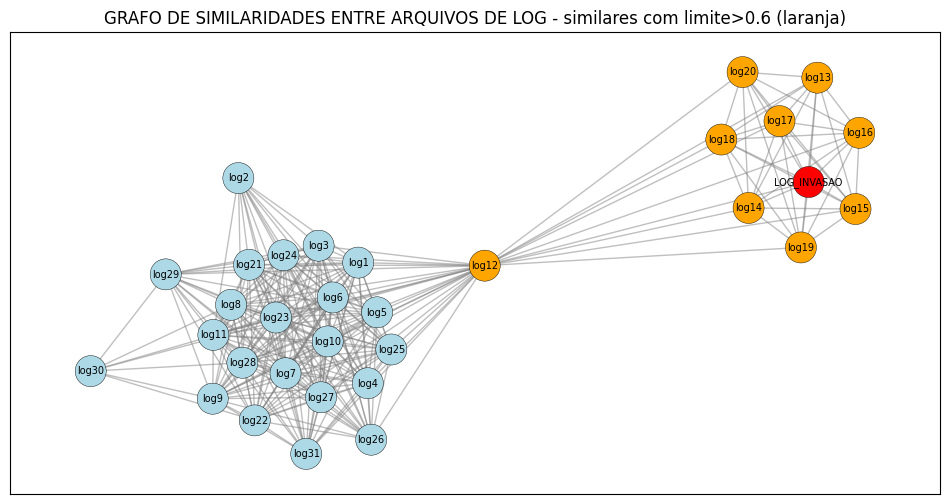

In [55]:
G = nx.Graph()
limite_similaridade = 0.6  # Ajustável

for i, dia1 in enumerate(dias):
    for j, dia2 in enumerate(dias):
        if i < j and df_sim.iloc[i, j] >= limite_similaridade:
            G.add_edge(dia1, dia2, weight=df_sim.iloc[i, j])

# Determinar cores dos nós
cores_nos = []
for node in G.nodes():
    if node == 'LOG_INVASAO':
        cores_nos.append('red')
    elif df_sim.loc['LOG_INVASAO', node] >= limite_similaridade and node != 'LOG_INVASAO':
        cores_nos.append('orange')
    else:
        cores_nos.append('lightblue')

# Layout e visualização
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 6))
# Primeiro, desenha as arestas
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# Depois, desenha os nós com borda preta
nx.draw_networkx_nodes(
    G, pos,
    node_color=cores_nos,
    edgecolors='black',      # 👈 borda preta
    linewidths=0.3,          # 👈 espessura da borda
    node_size=500            # (opcional: define tamanho)
)

# Por fim, os labels
nx.draw_networkx_labels(G, pos, font_size=7)

#nx.draw(G, pos, with_labels=True, node_color=cores_nos, edge_color='gray', font_size=8)
plt.title("GRAFO DE SIMILARIDADES ENTRE ARQUIVOS DE LOG - similares com limite>0.6 (laranja)")
plt.show()


In [ ]:
print(df_sim['LOG_INVASAO'].sort_values(ascending=False))


In [ ]:
similares = [node for node in G.nodes if df_sim.loc['LOG_INVASAO', node] >= limite_similaridade and node != 'LOG_INVASAO']
print(similares)

In [ ]:
num_nos = G.number_of_nodes()
num_arestas = G.number_of_edges()
componentes = nx.number_connected_components(G)
graus = [grau for _, grau in G.degree()]
grau_medio = sum(graus) / len(graus) if graus else 0

print(f"Número de nós: {num_nos}")
print(f"Número de arestas: {num_arestas}")
print(f"Número de componentes conectados: {componentes}")
print(f"Grau médio: {grau_medio:.2f}")

densidade = nx.density(G)
print(f"Densidade do grafo: {densidade:.4f}")

if nx.is_connected(G):
    diametro = nx.diameter(G)
    print(f"Diâmetro do grafo: {diametro}")
else:
    print("O grafo não é conexo. Não é possível calcular o diâmetro global.")

centralidade_grau = nx.degree_centrality(G)
mais_conectado = max(centralidade_grau.items(), key=lambda x: x[1])
print(f"Nó mais central (grau): {mais_conectado[0]} com centralidade {mais_conectado[1]:.4f}")

centralidade_proximidade = nx.closeness_centrality(G)
mais_proximo = max(centralidade_proximidade.items(), key=lambda x: x[1])
print(f"Nó mais central (proximidade): {mais_proximo[0]} com centralidade {mais_proximo[1]:.4f}")



In [59]:
## TF-IDF + k-NN e construção do grafo COM PLOTLY

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import networkx as nx

vetorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X = vetorizer.fit_transform(documentos_processados.values())
labels = list(documentos_processados.keys())

k = 3
nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(X)
distances, indices = nbrs.kneighbors(X)

G2 = nx.Graph()

for i, label in enumerate(labels):
    cluster = 0 if label == 'LOG_INVASAO' else 1
    G2.add_node(label, cluster=cluster, text=label)

for i, neighbors in enumerate(indices):
    for j in neighbors[1:]:
        G2.add_edge(labels[i], labels[j])

pos = nx.spring_layout(G2, seed=42)
for node in G2.nodes():
    G2.nodes[node]['pos'] = pos[node]

## 3. Visualização com Plotly

import plotly.graph_objects as go

def show_graph(G2):
    edge_x = []
    edge_y = []
    for edge in G2.edges():
        x0, y0 = G2.nodes[edge[0]]['pos']
        x1, y1 = G2.nodes[edge[1]]['pos']
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Pega vizinhos mais próximos do LOG_INVASAO
    idx_invasao = labels.index('LOG_INVASAO')
    neighbors_invasao = indices[idx_invasao][1:]
    labels_vizinhos_invasao = [labels[j] for j in neighbors_invasao]

    node_x = []
    node_y = []
    node_text = []
    node_color = []
    for node in G2.nodes():
        x, y = G2.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        node_text.append(G2.nodes[node]['text'])
        
        if node == 'LOG_INVASAO':
            node_color.append('red')
        elif node in labels_vizinhos_invasao:
            node_color.append('orange')
        else:
            cluster = G2.nodes[node]['cluster']
            if cluster == 0:
                node_color.append('lightcoral')
            else:
                node_color.append('lightblue')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition='top center',
        textfont=dict(size=10, color='black'),
        hoverinfo='text',
        marker=dict(
            showscale=False,
            color=node_color,
            size=15,
            line_width=0.5
        )
    )

    fig = go.Figure(data=[edge_trace, node_trace],
        layout=go.Layout(
            title=dict(
                text='GRAFO DE SIMILARIDADES ENTRE ARQUIVOS DE LOG - similares k-NN, k=3 (laranja)',
                font=dict(size=16)
            ),
            width=800,       # LARGURA DA FIGURA
            height=500,      # ALTURA DA FIGURA
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
    )
    fig.show()

    # Salva em PNG
    #fig.write_image("grafo.png", scale=2)

show_graph(G2)


In [ ]:
import networkx as nx

# Número de nós e arestas
num_nos = G2.number_of_nodes()
num_arestas = G2.number_of_edges()

# Componentes conectados
componentes = nx.number_connected_components(G2)

# Grau médio
graus = [grau for _, grau in G2.degree()]
grau_medio = sum(graus) / len(graus) if graus else 0

# Densidade
densidade = nx.density(G2)

# Diâmetro (se conexo)
if nx.is_connected(G2):
    diametro = nx.diameter(G2)
else:
    diametro = None

# Centralidade de grau
centralidade_grau = nx.degree_centrality(G2)
mais_conectado = max(centralidade_grau.items(), key=lambda x: x[1])

# Centralidade de proximidade
centralidade_proximidade = nx.closeness_centrality(G2)
mais_proximo = max(centralidade_proximidade.items(), key=lambda x: x[1])

# Exibir os resultados
print(f"Número de nós: {num_nos}")
print(f"Número de arestas: {num_arestas}")
print(f"Número de componentes conectados: {componentes}")
print(f"Grau médio: {grau_medio:.4f}")
print(f"Densidade do grafo: {densidade:.4f}")
if diametro is not None:
    print(f"Diâmetro do grafo: {diametro}")
else:
    print("O grafo não é conexo. Não é possível calcular o diâmetro global.")
print(f"Nó mais central (grau): {mais_conectado[0]} com centralidade {mais_conectado[1]:.4f}")
print(f"Nó mais central (proximidade): {mais_proximo[0]} com centralidade {mais_proximo[1]:.4f}")


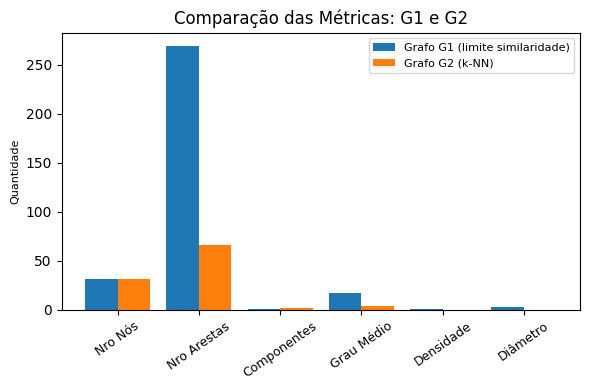

In [61]:
import matplotlib.pyplot as plt
import networkx as nx

def calcular_metricas_grafo(grafo):
    num_nos = grafo.number_of_nodes()
    num_arestas = grafo.number_of_edges()
    componentes = nx.number_connected_components(grafo)
    graus = [grau for _, grau in grafo.degree()]
    grau_medio = sum(graus) / len(graus) if graus else 0
    densidade = nx.density(grafo)
    diametro = nx.diameter(grafo) if nx.is_connected(grafo) else None
    return {
        'Nro Nós': num_nos,
        'Nro Arestas': num_arestas,
        'Componentes': componentes,
        'Grau Médio': grau_medio,
        'Densidade': densidade,
        'Diâmetro': diametro if diametro is not None else 0  # usar 0 para grafo desconexo
    }

# Calcular métricas reais
metricas_G = calcular_metricas_grafo(G)
metricas_G2 = calcular_metricas_grafo(G2)

# Plotagem
nomes_metricas = list(metricas_G.keys())
valores_G = list(metricas_G.values())
valores_G2 = list(metricas_G2.values())
x = range(len(nomes_metricas))

plt.figure(figsize=(6, 4))
plt.bar([i - 0.2 for i in x], valores_G, width=0.4, label='Grafo G1 (limite similaridade)')
plt.bar([i + 0.2 for i in x], valores_G2, width=0.4, label='Grafo G2 (k-NN)')

plt.xticks(ticks=x, labels=nomes_metricas, rotation=35, fontsize=9)
plt.ylabel("Quantidade", fontsize=8)
plt.title("Comparação das Métricas: G1 e G2", fontsize=12)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()
